# Scenario 3 subtask 1: Estimate the True Number of Infections

# Clean Version

**Background:** 10/2020 - 1/2021 in Greater Boston area. Predicting cases from wastewater potentially reports closer to the truth than testing.

## **TASK 1:** Replicate the fitting excersize (A) in Section 3.2 <br>
paper: https://doi.org/10.1016/j.scitotenv.2022.159326.

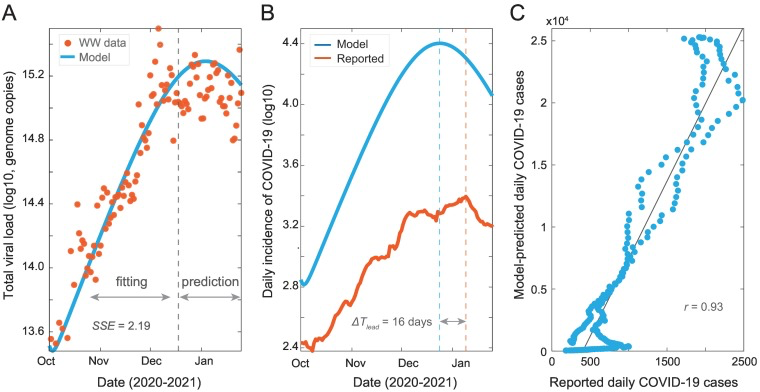

**Specifications:**
1. SEIR-V model
2. Fit $\lambda$, $\alpha$, and E(0).
3. Data found in supplementary materials
4. Simplify wherever necessary (e.g. fixed $\beta$)

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyciemss.visuals.plots as plots
from pyciemss.PetriNetODE.interfaces import (
    load_and_sample_petri_model,
    load_and_calibrate_and_sample_petri_model,
    load_petri_model,
    setup_petri_model,
    sample
)
from pyciemss.utils.interface_utils import convert_to_output_format
from pyciemss.utils import get_tspan

from mira.sources.askenet.petrinet import model_from_url
from mira.metamodel import Distribution
from mira.modeling.askenet.petrinet import AskeNetPetriNetModel
from mira.modeling import Model
import urllib.request, json
import requests

### Plot the Data:

V
time              
0     3.424864e+13
1     7.482611e+13
2     1.107730e+14
3     1.455132e+14
4     1.789461e+14
...            ...
221   1.256720e+17
222   1.257698e+17
223   1.258096e+17
224   1.258676e+17
225   1.259472e+17

[226 rows x 1 columns]

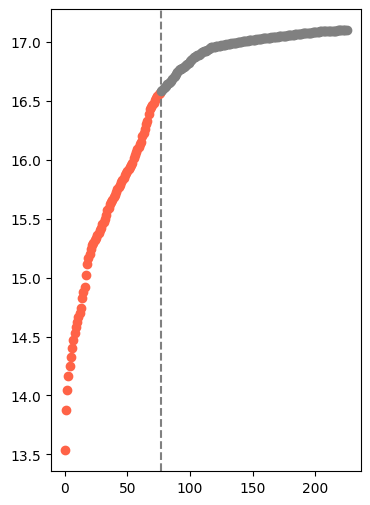

In [14]:
# Load Data
## This uses the cumsum() of the raw data
data_train = pd.read_csv('./data/processed_dataset_train.csv', index_col="time")
data_test  = pd.read_csv('./data/processed_dataset_test.csv', index_col="time")
data_whole = pd.read_csv('./data/processed_dataset.csv', index_col="time")
display(data_whole)

# Plot
plt.figure(figsize=(4,6))
plt.scatter(data_train.index, np.log10(data_train.V), color='tomato')
plt.scatter(data_test.index, np.log10(data_test.V), color='grey')
plt.axvline(77, linestyle='dashed', color='grey')

### Plot the Model:

In [32]:
SEIV_model_url  = "https://raw.githubusercontent.com/indralab/mira/hackathon2/notebooks/evaluation_2023.07/eval_scenario3_base.json"

raw = model_from_url(SEIV_model_url)
raw.parameters['lambda'].value = 9.06e-8
#raw.parameters['lambda'].distribution = Distribution(type="Uniform1", parameters={"minimum": 0, "maximum":2 * 9.06e-8})
raw.parameters['gamma'].value = 0.125
raw.parameters['beta'].value = 44852600
#raw.initials['E'].value = 1182
#raw.initials['V'].value = 1
print([(x, raw.parameters[x].value, raw.parameters[x].distribution) for x in raw.parameters])
print([(x, raw.initials[x].value) for x in raw.initials])

[('lambda', 9.06e-08, None), ('k', 0.3333333333333333, None), ('delta', 0.125, None), ('alpha', 500.0, Distribution(type='Uniform1', parameters={'minimum': 51.0, 'maximum': 796.0})), ('beta', 44852600, None), ('gamma', 0.125, None)]
[('S', 2300000.0), ('I', 0.0), ('E', 1000.0), ('V', 0.0)]


In [33]:
num_samples = 5
start_time = 0
end_time = 226 # between 10/02/2020 and 01/25/2021
num_timepoints = (end_time-start_time)*10 + 1
timepoints = list(get_tspan(start_time, end_time, num_timepoints).detach().numpy())

prior_samples = load_and_sample_petri_model(
        raw, num_samples, timepoints=timepoints,
    visual_options={"title": "3_base", "subset":["V_sol"]}, time_unit="days")

In [34]:
schema = plots.trajectories(pd.DataFrame(prior_samples["data"]), subset=".*_sol",
                            markers={"Training": 77},
                            points=data_whole.reset_index(drop=True).rename(columns={"V":"V_data"}))
schema = plots.pad(schema, 5)
plots.ipy_display(schema)

### Calibrate:

In [35]:
calibrated_samples = load_and_calibrate_and_sample_petri_model(
            raw,
            './data/processed_dataset_train.csv',
            5,
            timepoints=timepoints,
            num_iterations=2,
            visual_options={"title": "3_base", "subset":["V_sol"]}, time_unit="days")

/Users/krue284/Local Files/283-scen3/src/pyciemss/PetriNetODE/interfaces.py:848: UserWarning: Observation ObservationEvent(time=5.57419707547524e-06, observation={'V': tensor(3.4249e+13)}) is not in the range [0, 2301000.0]. This may be an error!
  warnings.warn(f"Observation {obs} is not in the range [0, {petri.total_population}]. This may be an error!")
/Users/krue284/Local Files/283-scen3/src/pyciemss/PetriNetODE/interfaces.py:848: UserWarning: Observation ObservationEvent(time=1.0000019073486328, observation={'V': tensor(7.4826e+13)}) is not in the range [0, 2301000.0]. This may be an error!
  warnings.warn(f"Observation {obs} is not in the range [0, {petri.total_population}]. This may be an error!")
/Users/krue284/Local Files/283-scen3/src/pyciemss/PetriNetODE/interfaces.py:848: UserWarning: Observation ObservationEvent(time=2.0000100135803223, observation={'V': tensor(1.1077e+14)}) is not in the range [0, 2301000.0]. This may be an error!
  warnings.warn(f"Observation {obs} is no

In [36]:
schema = plots.trajectories(pd.DataFrame(calibrated_samples["data"]), subset=".*_sol",
                            markers={"Training": 77},
                            points=data_whole.reset_index(drop=True).rename(columns={"V":"V_data"}))
schema = plots.pad(schema, 5)
plots.ipy_display(schema)

### Mimic the paper figure

In [ ]:
# TODO

## **TASK 3:** Repeat with uncertainty over the paper's parameters.

In [37]:
SEIV_model_url  = "https://raw.githubusercontent.com/indralab/mira/hackathon2/notebooks/evaluation_2023.07/eval_scenario3_base.json"

raw = model_from_url(SEIV_model_url)
raw.parameters['lambda'].value = 9.06e-8
raw.parameters['lambda'].distribution = Distribution(type="Uniform1",
                                                     parameters={"minimum": 0, "maximum":2 * 9.06e-8})
raw.parameters['gamma'].value = 0.125
raw.parameters['gamma'].distribution = Distribution(type="Uniform1",
                                                    parameters={"minimum": 0.04, "maximum":0.12})
raw.parameters['beta'].value = 44852600
print([(x, raw.parameters[x].value, raw.parameters[x].distribution) for x in raw.parameters])
print([(x, raw.initials[x].value) for x in raw.initials])

[('lambda', 9.06e-08, Distribution(type='Uniform1', parameters={'minimum': 0.0, 'maximum': 1.812e-07})), ('k', 0.3333333333333333, None), ('delta', 0.125, None), ('alpha', 500.0, Distribution(type='Uniform1', parameters={'minimum': 51.0, 'maximum': 796.0})), ('beta', 44852600, None), ('gamma', 0.125, Distribution(type='Uniform1', parameters={'minimum': 0.04, 'maximum': 0.12}))]
[('S', 2300000.0), ('I', 0.0), ('E', 1000.0), ('V', 0.0)]


In [38]:
num_samples = 5
start_time = 0
end_time = 226 # between 10/02/2020 and 01/25/2021
num_timepoints = (end_time-start_time)*10 + 1
timepoints = list(get_tspan(start_time, end_time, num_timepoints).detach().numpy())

prior_samples = load_and_sample_petri_model(
        raw, num_samples, timepoints=timepoints,
    visual_options={"title": "3_base", "subset":["V_sol"]}, time_unit="days")

In [39]:
schema = plots.trajectories(pd.DataFrame(prior_samples["data"]), subset=".*_sol",
                            markers={"Training": 77},
                            points=data_whole.reset_index(drop=True).rename(columns={"V":"V_data"}))
schema = plots.pad(schema, 5)
plots.ipy_display(schema)

### Calibrate:

In [44]:
calibrated_samples = load_and_calibrate_and_sample_petri_model(
            raw,
            './data/processed_dataset_train.csv',
            5,
            timepoints=timepoints,
            num_iterations=20,
            visual_options={"title": "3_base", "subset":["V_sol"]}, time_unit="days")

/Users/krue284/Local Files/283-scen3/src/pyciemss/PetriNetODE/interfaces.py:848: UserWarning: Observation ObservationEvent(time=4.161789092904655e-06, observation={'V': tensor(3.4249e+13)}) is not in the range [0, 2301000.0]. This may be an error!
  warnings.warn(f"Observation {obs} is not in the range [0, {petri.total_population}]. This may be an error!")
/Users/krue284/Local Files/283-scen3/src/pyciemss/PetriNetODE/interfaces.py:848: UserWarning: Observation ObservationEvent(time=1.0000107288360596, observation={'V': tensor(7.4826e+13)}) is not in the range [0, 2301000.0]. This may be an error!
  warnings.warn(f"Observation {obs} is not in the range [0, {petri.total_population}]. This may be an error!")
/Users/krue284/Local Files/283-scen3/src/pyciemss/PetriNetODE/interfaces.py:848: UserWarning: Observation ObservationEvent(time=2.0000016689300537, observation={'V': tensor(1.1077e+14)}) is not in the range [0, 2301000.0]. This may be an error!
  warnings.warn(f"Observation {obs} is n

In [45]:
schema = plots.trajectories(pd.DataFrame(calibrated_samples["data"]), subset=".*_sol",
                            markers={"Training": 77},
                            points=data_whole.reset_index(drop=True).rename(columns={"V":"V_data"}))
schema = plots.pad(schema, 5)
plots.ipy_display(schema)

In [46]:
# View what values the calibration landed on
display(calibrated_samples["data"])

timepoint_id  sample_id  lambda_param  alpha_param  gamma_param  \
0                 0          0  1.081941e-07   481.563782     0.057652   
1                 1          0  1.081941e-07   481.563782     0.057652   
2                 2          0  1.081941e-07   481.563782     0.057652   
3                 3          0  1.081941e-07   481.563782     0.057652   
4                 4          0  1.081941e-07   481.563782     0.057652   
...             ...        ...           ...          ...          ...   
11300          2256          4  1.115936e-07   439.565277     0.056966   
11301          2257          4  1.115936e-07   439.565277     0.056966   
11302          2258          4  1.115936e-07   439.565277     0.056966   
11303          2259          4  1.115936e-07   439.565277     0.056966   
11304          2260          4  1.115936e-07   439.565277     0.056966   

        k_param  delta_param  beta_param        E_sol         I_sol  \
0      0.333333        0.125  44852600.0  1000.000000  3.333334e-08   
1      0.333333        0.125  44852600.0   967.620300  3.258323e+01   
2      0.333333        0.125  44852600.0   937.081116  6.371988e+01   
3      0.333333        0.125  44852600.0   908.287598  9.348734e+01   
4      0.333333        0.125  44852600.0   881.152161  1.219591e+02   
...         ...          ...         ...          ...           ...   
11300  0.333333        0.125  44852600.0    36.299969  2.009171e+02   
11301  0.333333        0.125  44852600.0    36.065533  1.996198e+02   
11302  0.333333        0.125  44852600.0    35.832584  1.983308e+02   
11303  0.333333        0.125  44852600.0    35.601101  1.970509e+02   
11304  0.333333        0.125  44852600.0    35.371140  1.957785e+02   

              S_sol         V_sol  timepoint_days  
0      2.300000e+06  3.392353e-08        0.000000  
1      2.300000e+06  3.341234e+10        0.100000  
2      2.300004e+06  1.316594e+11        0.200000  
3      2.299998e+06  2.918766e+11        0.300000  
4      2.299994e+06  5.113520e+11        0.400000  
...             ...           ...             ...  
11300  4.347580e+05  2.775500e+17      225.600006  
11301  4.347569e+05  2.775504e+17      225.699997  
11302  4.347559e+05  2.775508e+17      225.800003  
11303  4.347557e+05  2.775510e+17      225.899994  
11304  4.347547e+05  2.775514e+17      226.000000  

[11305 rows x 13 columns]

**BONUS:** Use temperature data during fitting to replicate figure 3A. Prove that it improves fit.


In [ ]:
# TODO